# 01-Exploration

Goal of this notebook is to just explore the dataset, set up some basic utilities 

In [152]:
!pip install attrdict

In [164]:
!pip install timm

     |████████████████████████████████| 376 kB 5.1 MB/s eta 0:00:01


In [156]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict

import yaml



In [34]:
# check the package version to get reproducible env 
# source: https://www.kaggle.com/rtatman/get-the-versions-of-imported-packages

"""
To be used for kaggle notebook
"""

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.62.3
torch==1.9.1+cpu
seaborn==0.11.2
pandas==1.3.3
numpy==1.19.5
matplotlib==3.4.3


In [155]:
os.listdir("../input/config")

['config.yaml']

In [160]:



"""
To add to utility.py
"""

def seed_everything(seed=1234):
    """
    Utility function to seed everything
    source: https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    

def read_yaml(filename):
    """
    Read yaml configuation and returns the dict

    Parameters
    ----------
    filename: string
        Path including yaml file name
    """

    with open(filename) as f:
        config = yaml.safe_load(f)

    return config


    
# configs

# config is different in kaggle


class BaseConfigLoader:
    
    def __init__(self,config_path):
        # TODO: if None, should load yaml
        self.config = read_yaml(config_path)
            
    def load_config(self):
        return AttrDict(self.config)

In [172]:
# load config

base_config_manager = BaseConfigLoader("../input/d/germmie/config/config.yaml")


# Loading Data

We will load the data by creating torch datasets as well as dataloader

In [ ]:
seed_everything()

In [163]:
# this is specific to kaggle
# if running in GCS, replace with our GCP bucket 
# get cache location of the dataset 
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()
file_path = base_config_manager.load_config().filepath.kaggle #"/kaggle/input/petfinder-pawpularity-score/"


train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))


In [14]:
train_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [78]:
test_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


In [106]:
class pawnetDataset(torch.utils.data.Dataset):
    """
    Dataset
    Based on template https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self,annotation_df, img_dir,transform=None,target_transform=None,test=False):
        self.annotation_df = annotation_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.test=test # if dataset contains labels 
        
        
    def __len__(self):
        """Define 1 epoch"""
        return len(self.annotation_df)
    
    def __getitem__(self,idx):
        """called batch num of times"""
        img_path = os.path.join(self.img_dir, self.annotation_df.iloc[idx, 0]) # ID is column index 0
        image = read_image(img_path+".jpg")
        if self.test:
            label = 0
        else:
            label = self.annotation_df.iloc[idx, 13] # Pawpularity is column index 13
            
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [130]:
# create loaders - just for visualization
# for visualization, we need them to be in the same size
file_path = "/kaggle/input/petfinder-pawpularity-score/"
train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = T.Compose([T.Resize([224,224])]))
test_data = pawnetDataset(annotation_df=test_df,img_dir = os.path.join(file_path,"test"),transform = T.Compose([T.Resize([224,224])]),test=True)
train_loaders = torch.utils.data.DataLoader(train_data,batch_size=30,shuffle=False)
test_loaders = torch.utils.data.DataLoader(test_data,batch_size=39,shuffle=False)

In [132]:
# helper to visualize
# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

def visualize_images(images,nmax):
    """
    visual images in our loaders
    
    Parameters
    ---------
    images: image tensor of size (N,H,W,C)
    nmax: max number of images to plot
    """
    fig,axes = plt.subplots(figsize=(16,16))
    axes.set_xticks([])
    axes.set_yticks([])
    axes.imshow( make_grid((images.detach()[:nmax]),nrow=6).permute(1,2,0)) # H,W,C
    plt.savefig("train_batch_images.png")
    
def visualize_batch_images(data_loaders,nmax=64):
    images, labels = iter(data_loaders).next() # get batch size of image tensor
    visualize_images(images,nmax=nmax)

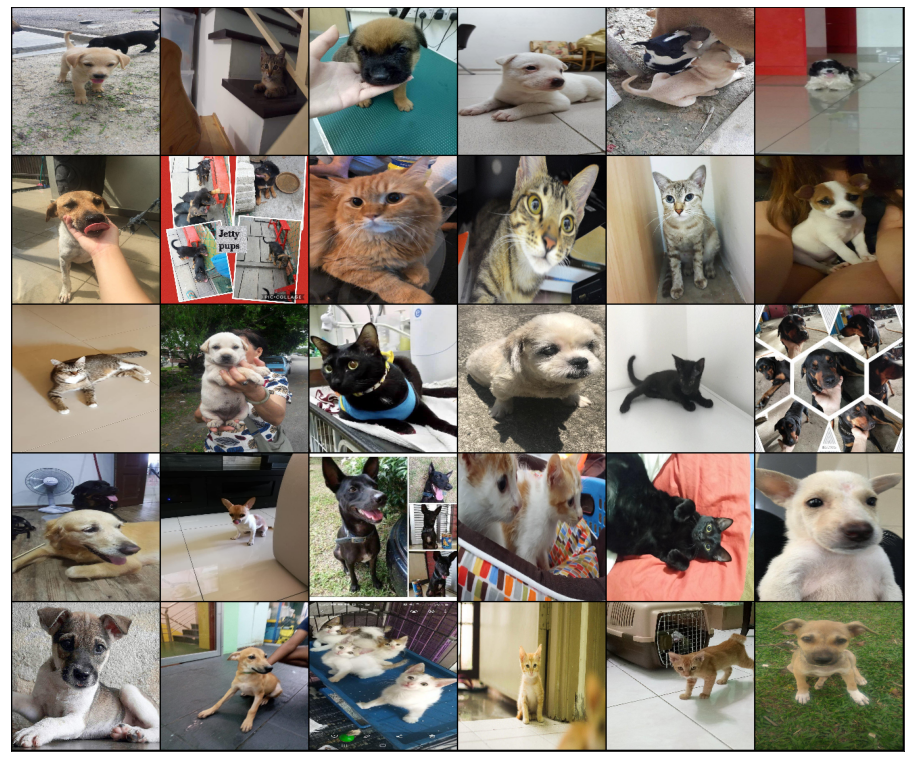

In [133]:
visualize_batch_images(train_loaders)

# Meta data

Exploring meta data, train distribution

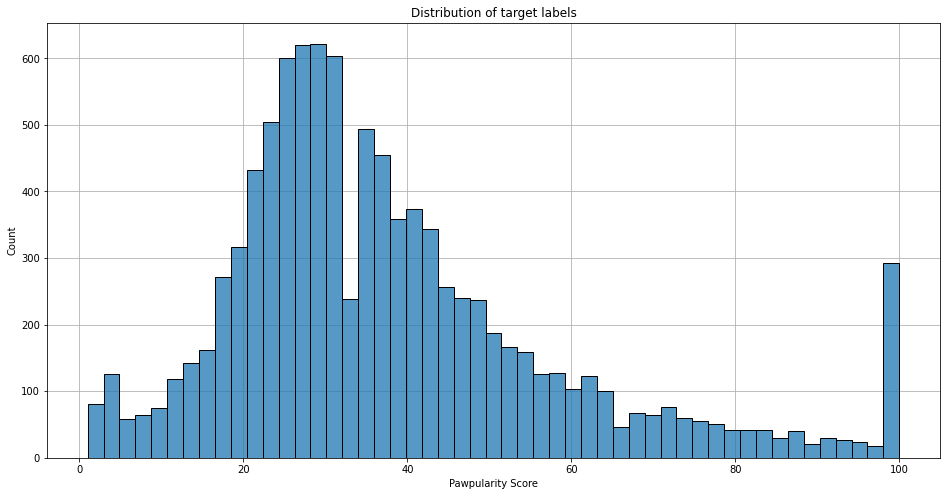

In [147]:
fig,axes = plt.subplots(figsize=(16,8))
sns.histplot(train_df["Pawpularity"].values,ax=axes)
axes.set_xlabel("Pawpularity Score")
axes.set_title("Distribution of target labels")
axes.grid()
axes.set_axisbelow(True)

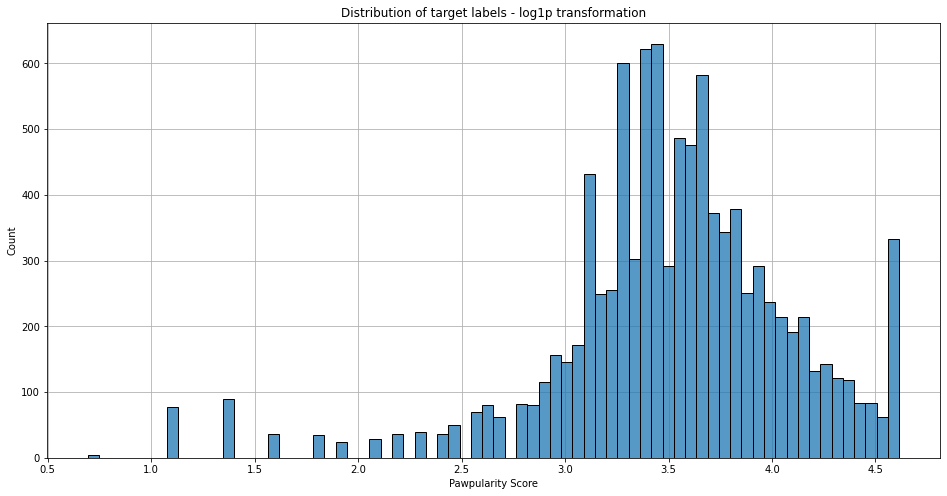

In [148]:
fig,axes = plt.subplots(figsize=(16,8))
sns.histplot(np.log1p(train_df["Pawpularity"].values),ax=axes)
axes.set_xlabel("Pawpularity Score")
axes.set_title("Distribution of target labels - log1p transformation")
axes.grid()
axes.set_axisbelow(True)


In [150]:
# normalization to 0-1 softlabels
from sklearn.preprocessing import MinMaxScaler
og_labels = train_df["Pawpularity"].values.copy()
scaler = MinMaxScaler() # 0 to 1
soft_labels = scaler.fit_transform(og_labels.reshape((-1,1)))


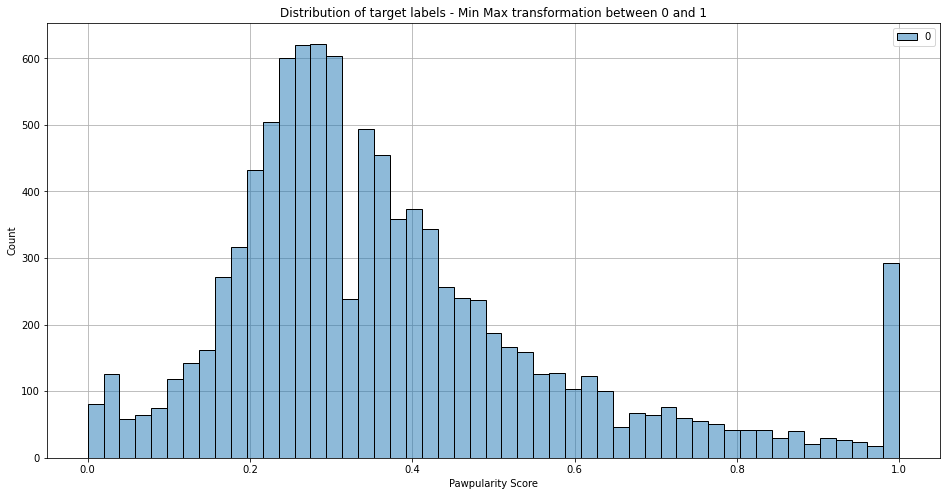

In [151]:
fig,axes = plt.subplots(figsize=(16,8))
sns.histplot(soft_labels,ax=axes)
axes.set_xlabel("Pawpularity Score")
axes.set_title("Distribution of target labels - Min Max transformation between 0 and 1")
axes.grid()
axes.set_axisbelow(True)


# Train basic models 

In [165]:
import torch
from torch import nn
import torch.nn.functional as F

from timm import create_model


In [177]:


class pawNetBasic(nn.Module):
    """
    First cut basic pawNet model
    we will improve on this - this serves as skeleton code
    for other models
    
    timm contains collection of several pretrained models
    """
    
    def __init__(self,dropout=0.2):
        super().__init__()
        self.dropout = 0.2
        
        # initialize layers
        # https://fastai.github.io/timmdocs/tutorial_feature_extractor
        # remove FCL by setting num_classes=0
        self.pretrained = create_model(
            base_config_manager.load_config().model.pretrained, 
            pretrained=True, 
            num_classes=1, 
            in_chans=3
        )
        
    def forward(self,x):
        out = self.pretrained(x)
        
        return out 
        

In [197]:
def train_model(model,train_loader,criterion,optimizer,device = "cpu"):
    """
    Trains model for 1 epoch
    """
    model.train()
    for i, (x_,y_) in enumerate(train_loader):
        # zero the parameter gradients stored 
        optimizer.zero_grad()
        # forward 
        x_ = x_.to(device)
        y_ = y_.to(device)
        y_pred = model(x_.to(torch.float))
        loss = criterion(y_pred.squeeze(),y_.to(torch.float))
        # backward
        loss.backward()
        # update
        optimizer.step()
    
    return loss.item()


# need to disable auto grad
# @torch.no_grad()
def evaluate(model,valid_loader,criterion,device= "cpu"):
    model.eval()
    y_valid = []
    y_pred_valid = []
    for i, (x,y) in enumerate(valid_loader):
        with torch.no_grad():
#             pred = model(x.to(torch.double).to(device))
            pred = model(x.to(device))
            y_pred_valid.append(pred.squeeze().detach().cpu())
            y_valid.append(y.detach().cpu())
    # convert from list to tensor
    y_valid = torch.cat(y_valid,0)
    y_pred_valid = torch.cat(y_pred_valid,0)

    valid_loss = criterion(y_pred_valid,y_valid)
    
    return valid_loss.item()

In [195]:
seed_everything()

model = pawNetBasic()

In [183]:
criterion = torch.nn.BCEWithLogitsLoss()
optimzer = torch.optim.Adam(model.parameters()) # lr=0.0001

# Preparing for training

* create relevant transformations, validation splits

In [188]:
"""
All pre-trained models expect input images normalized in the same way, 
i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
where H and W are expected to be at least 224. 
The images have to be loaded in to a range of [0, 1] and then 
normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
You can use the following transform to normalize:

https://pytorch.org/vision/stable/models.html

"""
train_transformation = T.Compose(
            [
                T.Resize([224,224]),# imgnet needs at least 224
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
            ]
        )
train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = train_transformation)
# batchsize should be parameter in config
train_loader = torch.utils.data.DataLoader(train_data,batch_size=30,shuffle=True)


In [184]:
# training loop
early_stopping_patience = 10
early_stopping_counter = 0
train_loss_list = []
valid_loss_list = []
best_valid = np.inf
device = 'cuda' if torch.cuda.is_available() else 'cpu' 



for epoch in range(1):
    loss = train_model(model,train_loader,criterion,optimzer,device=device)
    valid_loss = None
#     valid_loss = evaluate(model,valid_loader,criterion,device=device)
    logger.info(f"Epoch: {epoch} | BCElogitloss:{loss} | valid BCElogitloss: {valid_loss} ")
    
    
    train_loss_list.append(loss)
    valid_loss_list.append(valid_loss)
    # check early stopping
    if epoch >0:
        # check better than best, if not ...
        if best_valid < valid_loss:
            early_stopping_counter+=1
        else:
            early_stopping_counter = 0
            best_valid = valid_loss
            best_model = copy.deepcopy(model)
        
        if early_stopping_counter == early_stopping_patience:
            break
            logger.info("Early stopping activated")

torch.save(model.state_dict(),"pawnet.pt")

NameError: name 'train_loader' is not defined

In [ ]:
device="cpu"
loss = train_model(model,train_loader,criterion,optimzer,device=device)